# CREATING A INTELLIGENT AGENT TO PLAY CHROME DINO

## SETTING THE ENVIRONMENT

Importing the pertinent libraries:

In [1]:
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

## EXPLORATORY DATA ANALYSIS

Loading the data (used the second version of the data, which captured the behavior of an initial intelligent agent):

In [2]:
data = pd.read_csv('../dino_game/data/new_dino.csv')

data.head()

,x,obstacle,move
0,913,1,Run
1,893,1,Run
2,873,1,Run
3,853,1,Run
4,832,1,Run


General dataset information:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   x         1214 non-null   int64 
 1   obstacle  1214 non-null   int64 
 2   move      1214 non-null   object
dtypes: int64(2), object(1)
memory usage: 28.6+ KB


Transforming variables into numerical values and balancing the data:

In [4]:
moves_encoder = {'Run'  : 0,
                 'Jump' : 1,
                 'Duck' : 2}
label_encoder = {value: key
                 for key, value in moves_encoder.items()}

data.move = data.move.map(moves_encoder)
data, _   = RandomUnderSampler().fit_resample(data, data.move)

Checking the amount of data remaining:

In [5]:
print(f'Left {len(data)} samples...')

Left 279 samples...


Checking the data graphically, it can be seen that:

- A large horizontal distance leads the agent to remain just running
- When approaching an obstacle 0 (bird) it should lower
- When approaching an obstacle 1 (cactus) it should jump

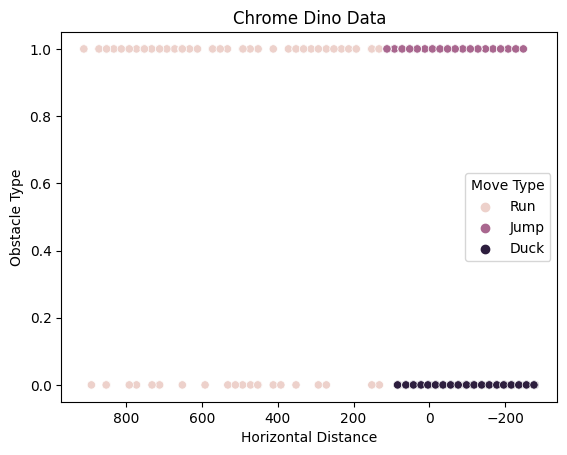

In [6]:
sns.scatterplot(data=data, x='x', y='obstacle', hue='move')

plt.title('Chrome Dino Data')
plt.xlabel('Horizontal Distance')
plt.ylabel('Obstacle Type')

legend = plt.legend(title='Move Type')
for label, move in label_encoder.items():
    legend.get_texts()[label].set_text(move)

plt.gca().invert_xaxis()

plt.show()

Preparing the data for training:

Obs.: Since we'll be testing the models in the game's own environment, we won't split the data between training and testing.

In [7]:
X = data[['x', 'obstacle']]
y = data.move

X_train = X.to_numpy()
y_train = y.to_numpy()

## DECISION TREE CLASSIFIER

Training a decision tree model (the maximum depth of the tree was limited in order to obtain a less fragmented and more interpretable decision limit):

In [8]:
clf_tree = DecisionTreeClassifier(max_depth=2)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

Evaluating the results:

In [9]:
print("Getting the relevants features:")

print()

for i, v in enumerate(clf_tree.feature_importances_):
    if v:
        print(f"X[{i}] = {data.columns[i]} ({v})")

Getting the relevants features:

X[0] = x (0.5000000000000001)
X[1] = obstacle (0.49999999999999994)


In [10]:
print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Ein = {(1 - clf_tree.score(X_train, y_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_train, clf_tree.predict(X_train)),
                   index=['f(x)=0', 'f(x)=+1', 'f(x)=+2'],
                   columns=['h(x)=0', 'h(x)=+1', 'h(x)=+2']))

print()
print(classification_report(y_train, clf_tree.predict(X_train)))

Analyzing the results obtained with DecisionTreeClassifier:

Ein = 0.00%

         h(x)=0  h(x)=+1  h(x)=+2
f(x)=0       93        0        0
f(x)=+1       0       93        0
f(x)=+2       0        0       93

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        93

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



At this point, we can see:

- The importance of the features was equal in the training, indicating that both are essential to the agent
- The training led to seamless learning of the data

A key aspect in interpreting the model is plotting the decision region:

- Since the data collected is limited to the game screen or booleans, it is presented in a well-defined way
- It can be seen that the x-axis is mirrored to simulate the game screen
- The decision boundary follows the trend of movements perceived in the exploratory analysis of the data

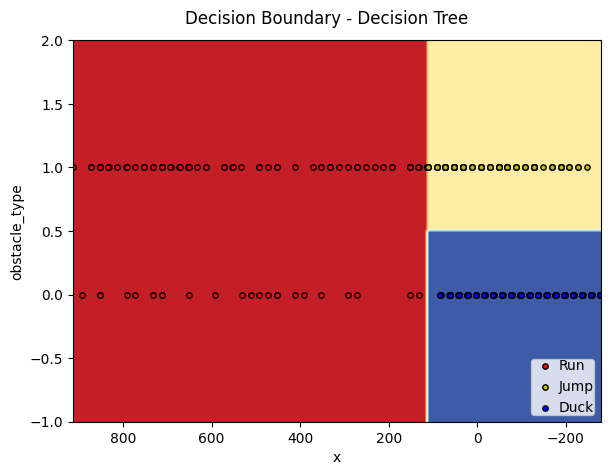

In [11]:
n_classes = 3
plot_colors = 'ryb'

# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    clf_tree,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='obstacle_type'
)

# Displaying the data
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)

    plt.scatter(
        X.iloc[idx[0], 0],
        X.iloc[idx[0], 1],
        c=color,
        label=label_encoder[i],
        edgecolor='black',
        s=15
    )

plt.gca().invert_xaxis()

plt.suptitle('Decision Boundary - Decision Tree')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

A simple and very interpretable tree can be plotted:

- First, the minimum horizontal distance is checked, the dinosaur remains running if not met
- Second, once the minimum distance is met, the type of obstacle is checked to define the necessary movement

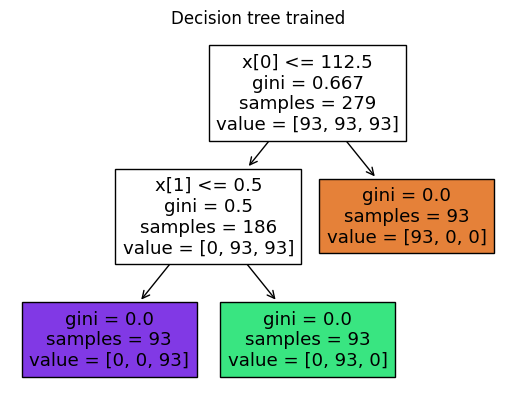

In [12]:
plot_tree(clf_tree, filled=True)
plt.title("Decision tree trained")
plt.show()

Saving the model:

In [13]:
with open('../dino_game/models/dtc.pkl','wb') as f:
    pickle.dump(clf_tree, f)

## SVM

Training an SVM with linear kernel:

In [14]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

SVC(kernel='linear')

Evaluating the results:

In [15]:
predict = svm_linear.predict(X_train)

print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"Ein = {(1 - svm_linear.score(X_train, y_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_train, predict),
                   index=['f(x)=0', 'f(x)=+1', 'f(x)=+2'],
                   columns=['h(x)=0', 'h(x)=+1', 'h(x)=+2']))

print()
print(classification_report(y_train, predict))

Analyzing the results obtained with SupportVectorMachine:

Ein = 0.00%

         h(x)=0  h(x)=+1  h(x)=+2
f(x)=0       93        0        0
f(x)=+1       0       93        0
f(x)=+2       0        0       93

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        93

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



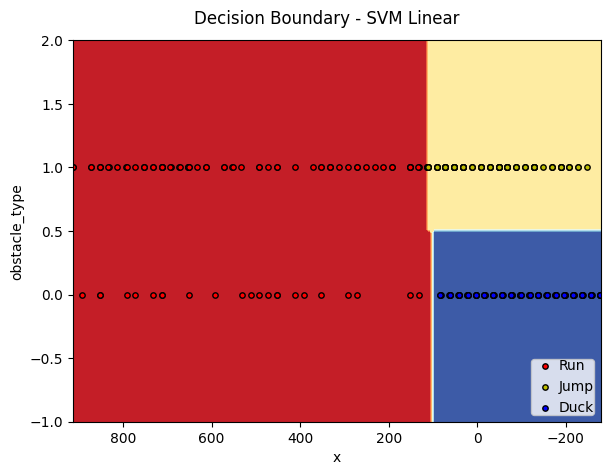

In [16]:
n_classes = 3
plot_colors = 'ryb'

# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    svm_linear,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='obstacle_type',
)

# Displaying the data
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)

    plt.scatter(
        X.iloc[idx[0], 0],
        X.iloc[idx[0], 1],
        c=color,
        label=label_encoder[i],
        edgecolor='black',
        s=15
    )

plt.gca().invert_xaxis()

plt.suptitle('Decision Boundary - SVM Linear')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

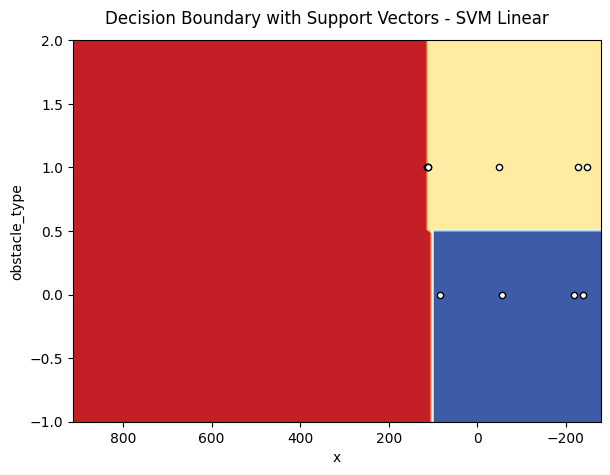

In [17]:
# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    svm_linear,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='obstacle_type',
)

# Displaying the support vectors
plt.scatter(
    svm_linear.support_vectors_[:, 0],
    svm_linear.support_vectors_[:, 1],
    s=20,
    facecolors='white',
    zorder=10,
    edgecolors='k'
)

plt.gca().invert_xaxis()

plt.suptitle('Decision Boundary with Support Vectors - SVM Linear')
_ = plt.axis('tight')

Obs.: It can be seen that the result was similar to that of the decision tree, with the hyperplanes adjusted in a similar way to being parallel to the axes.

Saving the model:

In [18]:
with open('../dino_game/models/svm_linear.pkl','wb') as f:
    pickle.dump(svm_linear, f)